In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-ADE"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [4]:
ade_corpus_dataset = load_dataset(
    "ought/raft", 
    name="ade_corpus_v2" , 
    cache_dir= "/Data/pedro.silva"
)

In [5]:
train_dataset = ade_corpus_dataset['train'].add_column(
    "labels",
    list(map(lambda x: x- 1, ade_corpus_dataset['train']['Label']))
)

test_dataset = ade_corpus_dataset['test'].add_column(
    "labels",
    list(map(lambda x: x- 1, ade_corpus_dataset['test']['Label']))
)

In [6]:
classes = np.unique(train_dataset['labels'], return_counts=True)
classes

(array([0, 1]), array([15, 35]))

In [7]:
classes_names = ["Non ADE related", "ADE related"]

In [8]:
num_classes = len(classes[0])

In [9]:
num_classes

2

In [10]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = []

    for i in range(len(train_dataset['labels'])):
        label = train_dataset['labels'][i]
        text = train_dataset['Sentence'][i]
        indexes_dict[label].append(text)


    train_data = {
        'labels': [],
        'text': []
    }

    validation_data = {
        "labels" : [],
        "text": []
    }

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])
        size = int(train_size * n)

        train_data['text'] += indexes_dict[label][:size]
        train_data['labels'] += [label]*size
        
        validation_data['text'] +=indexes_dict[label][size:]
        validation_data['labels'] += [label]* (n-size)

    return train_data, validation_data

In [17]:
train, val = stratified_train_test_split(
    train_dataset,
    classes,
    0.6
)

In [18]:
np.unique(train['labels'], return_counts=True)

(array([0, 1]), array([ 9, 21]))

In [19]:
np.unique(val['labels'],return_counts=True)

(array([0, 1]), array([ 6, 14]))

## Focal Loss Fn

In [20]:
_, class_counts = np.unique(
    train['labels'],
    return_counts=True,
)

alpha = len(train['labels'])/class_counts

In [21]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 2,
    alpha= alpha
)

In [51]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['labels'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
)


val_dataloader = get_dataloader(
    val['text'],
    val['labels'],
    tokenizer,
    n_shots = 100,
    num_classes=num_classes,
    equalize_class=False
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=10
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 30/30 [00:00<00:00, 30.42it/s]


tensor(0.2500, device='cuda:0')
tensor(0.2500, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 31.00it/s]


tensor(0.8235, device='cuda:0')
tensor(0.8235, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.98it/s]


tensor(0.7879, device='cuda:0')
tensor(0.7879, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.95it/s]


tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.92it/s]


tensor(0.8276, device='cuda:0')
tensor(0.8276, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.92it/s]


tensor(0.8667, device='cuda:0')
tensor(0.8667, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 31.00it/s]


tensor(0.8667, device='cuda:0')
tensor(0.8667, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 31.01it/s]


tensor(0.8667, device='cuda:0')
tensor(0.8667, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.98it/s]


tensor(0.8667, device='cuda:0')
tensor(0.8667, device='cuda:0')


100%|██████████| 30/30 [00:00<00:00, 30.96it/s]


tensor(0.8667, device='cuda:0')
tensor(0.8667, device='cuda:0')


In [49]:
history

{'val_f1': [0.0,
  0.8235293626785278,
  0.8235293626785278,
  0.8235293626785278,
  0.8235293626785278,
  0.7878788113594055,
  0.7878788113594055,
  0.8387096524238586,
  0.8666666150093079,
  0.8275862336158752],
 'conf_matrix': None,
 'val_conf_matrix': tensor([[ 3,  3],
         [ 1, 13]], device='cuda:0'),
 'y_pred': tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        device='cuda:0'),
 'y_true': tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0')}

In [50]:
binary_f1_score(
    history['y_pred'],
    history['y_true']
)

tensor(0.8667, device='cuda:0')

Text(0, 0.5, 'F1 score')

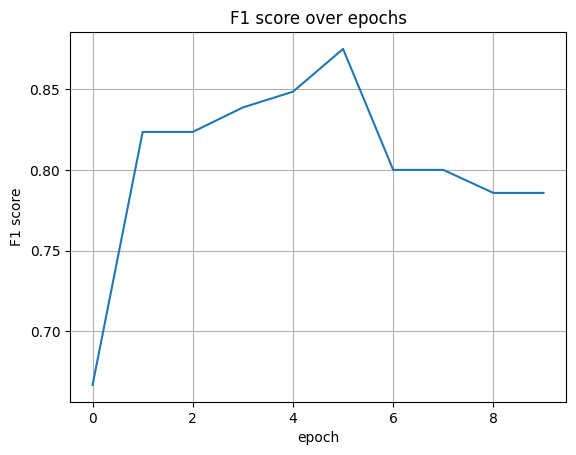

In [45]:
plt.plot(history['val_f1'])
plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-ADE')

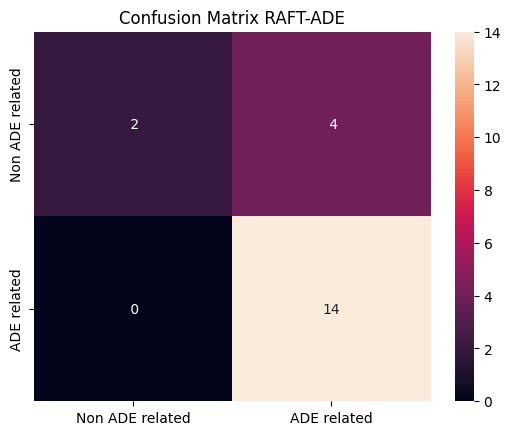

In [47]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name}")

## Generating submission

In [55]:
test_dataset

Dataset({
    features: ['Sentence', 'ID', 'Label', 'labels'],
    num_rows: 5000
})

In [56]:
test_dataset[0]

{'Sentence': 'CONCLUSIONS: SD-OCT and AO detected abnormalities that correlate topographically with visual field loss from hydroxychloroquine toxicity as demonstrated by HVF 10-2 and may be useful in the detection of subclinical abnormalities that precede symptoms or objective visual field loss.',
 'ID': 50,
 'Label': 0,
 'labels': -1}

In [122]:
model = trainer.best_model
submission = pd.DataFrame()

for i in tqdm(range(len(test_dataset))):
    text = test_dataset[i]['Sentence']
    id = test_dataset[i]['ID']

    tokens = tokenizer(
        text,
        truncation= True,
        padding= "max_length",
        return_tensors= "pt",
        max_length=256,
    )

    for k,v in tokens.items():
        tokens[k] = v.to(device)

    pred = model(**tokens)\
        .logits\
        .argmax()\
        .to('cpu')\
        .item()

    this_row = pd.DataFrame({'ID' : id, "Label": pred}, index = [i])

    submission = pd.concat([submission, this_row],)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:38<00:00, 131.49it/s]


In [123]:
class_label_keymap = { i-1: test_dataset.features['Label'].names[i] for i in range(num_classes +1)} 

In [124]:
class_label_keymap

{-1: 'Unlabeled', 0: 'ADE-related', 1: 'not ADE-related'}

<Axes: ylabel='Frequency'>

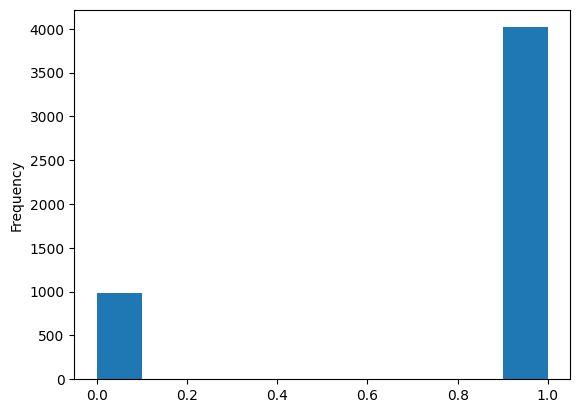

In [125]:
submission['Label'].plot.hist()

In [126]:
submission['Label'] = submission['Label'].map(class_label_keymap)

submission.to_csv("submissions/finetuning/ade_corpus/predictions.csv", index = False)

In [ ]:
from pathlib import Path
import pandas as pd
from collections import Counter
from datasets import load_dataset, get_dataset_config_names

tasks = get_dataset_config_names("ought/raft")

for task in tasks:
    # Load dataset
    raft_subset = load_dataset("ought/raft", task)
    # Compute majority class over training set
    counter = Counter(raft_subset["train"]["Label"])
    majority_class = counter.most_common(1)[0][0]
    # Load predictions file
    preds = pd.read_csv(f"submissions/finetuning/{task}/predictions.csv")
    # Convert label IDs to label names
    preds["Label"] = raft_subset["train"].features["Label"].int2str(majority_class)
    # Save predictions
    preds.to_csv(f"data/{task}/predictions.csv", index=False)


In [ ]:
t